# Introduction

**Project Goal:** The goal of this project is to identify whether a tweet is a disaster tweet or not. In this age many people go to twitter on updates during times of emergency. People observing something in real time can report a disaster through twitter and increase notification. Being able to identify what is a real disaster and what is not can help people get notified of disasters around them. Agencies are looking into monitoring twitter for information on disasters in real time. 

**Dataset:** This dataset contains tweets and are labeled as a disaster tweet or regular tweet. It has 7613 entries and 5 columns. 
The data is formatted as:
* text of a tweet
* kewyword from that tweet
* location

Target is either 0(not a disaster) or 1(disaster)

**Citation:** Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.

Github: 

For this project I will be utilizing LSTM to build a model to classify the given tweets. 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(df.head())
print(df.shape)


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
(7613, 5)


In [ ]:
df.sample(5)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis

Check **class distribution** for how the data is spread out. Look for major imbalances. Here there are more non-disaster tweets than disaster tweets. 

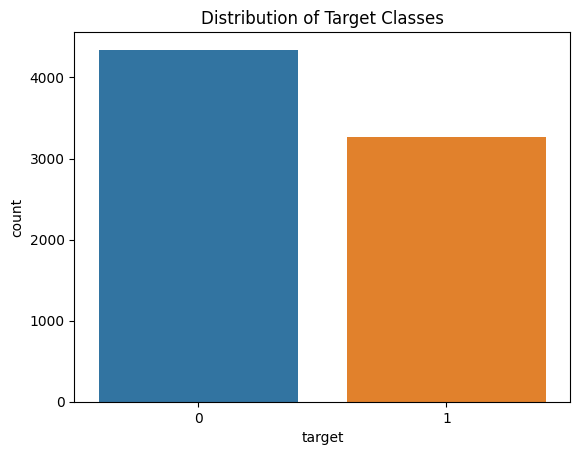

In [4]:
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Classes')
plt.show()

There is a slight imbalance with more non-disaster tweets compared to disaster tweets. 

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

In [6]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS

Next **preprocess** the text to remove urls, punctuations, whitespace, and special characters. Then tokenize the words to feed into the NLP with more ease. 

In [7]:

def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [PorterStemmer().stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)

Example of how the clean text looks.

In [ ]:
print(df['clean_text'][0])

Next I counted the frequent words in each text to understand what words are significant in a non-disaster tweet versus a disaster tweet. 

In [8]:
disaster_words = ' '.join(df[df['target'] == 1]['clean_text']).split()
non_disaster_words = ' '.join(df[df['target'] == 0]['clean_text']).split()

disaster_freq = Counter(disaster_words)
non_disaster_freq = Counter(non_disaster_words)

print("Common words in disaster tweets:", disaster_freq.most_common(10))
print("Common words in non-disaster tweets:", non_disaster_freq.most_common(10))

Common words in disaster tweets: [('bomb', 182), ('kill', 159), ('news', 140), ('flood', 120), ('disast', 118), ('california', 115), ('crash', 113), ('suicid', 110), ('train', 109), ('polic', 107)]
Common words in non-disaster tweets: [('like', 307), ('im', 249), ('just', 234), ('amp', 193), ('new', 170), ('dont', 154), ('love', 117), ('bodi', 117), ('bag', 111), ('time', 106)]


The most common words in disaster tweets are bomb, kill and news while the most common words in non-disaster tweets are like, im, and just. 

In [9]:
from wordcloud import WordCloud

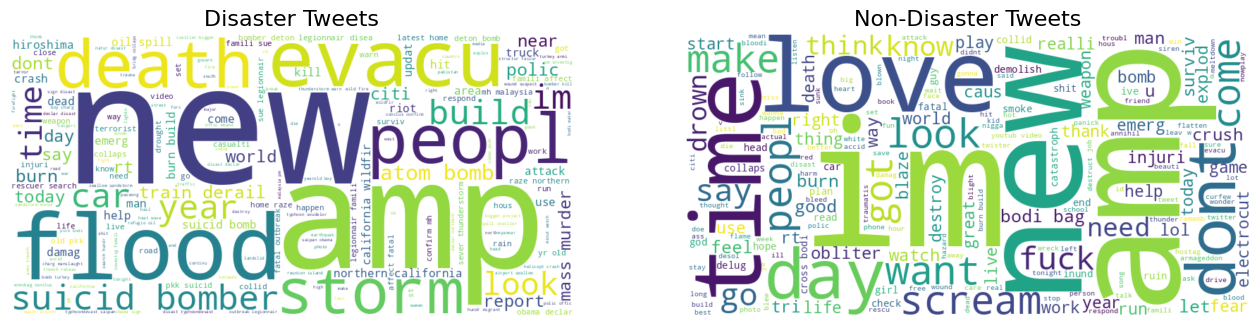

In [10]:
disaster_text = " ".join(df[df["target"] == 1]["clean_text"])
non_disaster_text = " ".join(df[df["target"] == 0]["clean_text"])


disaster_wc = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
non_disaster_wc = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(disaster_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Disaster Tweets', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(non_disaster_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Disaster Tweets', fontsize=16)

plt.show()

Using **Word Clouds** we can see what are the major indicating words of a disaster tweet and a non-disaster tweet. Words like amp, im, and people are common in both styles of tweets so those are indicators while flood death and suicide are specific to disaster tweets. 

# Model Building/Analysis

For this model I am implementing **LSTMs** into the neural network. 

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



tokenizer=Tokenizer(num_words=3000,split=' ')
tokenizer.fit_on_texts(df['clean_text'].values)
X = tokenizer.texts_to_sequences(df['clean_text'].values)
X = pad_sequences(X)

2025-04-28 02:14:29.231950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745806469.460089      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745806469.524317      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
from sklearn.model_selection import train_test_split
y = df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

The design for this model is specific to Text Classification. For tweets the order of words can change the connotation of the tweet which is important in inferring whether a tweet is a disaster or not. First step is to use an embedding layer which converts each word into a vector of size 64. The using an LSTM layer it allows the model to remember important earlier words when predicting on newer words. 

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras import Input

vocab_size = 10000
embedding_dim = 64
max_length = 100

model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2025-04-28 02:14:42.765218: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6435 - loss: 0.6267 - val_accuracy: 0.8004 - val_loss: 0.4395
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8496 - loss: 0.3708 - val_accuracy: 0.7859 - val_loss: 0.4601
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8758 - loss: 0.2988 - val_accuracy: 0.7899 - val_loss: 0.4841
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8879 - loss: 0.2693 - val_accuracy: 0.7781 - val_loss: 0.5438
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9114 - loss: 0.2276 - val_accuracy: 0.7577 - val_loss: 0.5945
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9238 - loss: 0.1903 - val_accuracy: 0.7610 - val_loss: 0.6760
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9359 - loss: 0.1703 - val_accuracy: 0.7597 - val_loss: 0.8148
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9518 - loss: 0.1292 - val_accu

In [15]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_val, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       874
           1       0.69      0.68      0.69       649

    accuracy                           0.74      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



The model works fairly well with no imbalances it is treating both classes fairly equally. It is slightly better at predicting non-disaster tweets compared to disaster tweets. Let's try using a bidirectional LSTM and with a higher embedding dimension. We are also using early stopping which is a callback that automatically stops training when it is no longer getting better to prevent overfitting.

In [16]:
vocab_size = 10000
embedding_dim = 100
max_length = 100

model = Sequential([
    Input(shape=(max_length,)),  
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,084,609 (4.14 MB)

 Trainable params: 1,084,609 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6415 - loss: 0.6288 - val_accuracy: 0.8070 - val_loss: 0.4390
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8490 - loss: 0.3734 - val_accuracy: 0.7984 - val_loss: 0.4476
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8816 - loss: 0.3011 - val_accuracy: 0.7741 - val_loss: 0.5236
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8977 - loss: 0.2670 - val_accuracy: 0.7807 - val_loss: 0.5695
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9201 - loss: 0.2114 - val_accuracy: 0.7682 - val_loss: 0.6007
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9290 - loss: 0.1851 - val_accuracy: 0.7466 - val_loss: 0.6712


In [18]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_val, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       874
           1       0.81      0.71      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.80      1523



The results indicat a fairly well performing classifier with an accurcy of 0.81. There is a slight imbalance in recall where we are misidentifying negative tweets as positive. The precision accuracy for both classes is 0.81 which means it is classifying tweets fairly well. It seems to play it safe only identifying disaster tweets when confident. It misses some true disaster tweets but does not give high false positives which in this case is costly. 

In [19]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df['clean_text'] = test_df['text'].apply(preprocess)


In [20]:
X_test = tokenizer.texts_to_sequences(test_df['clean_text'].values)
X_test = pad_sequences(X_test, maxlen=X.shape[1])

In [21]:
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int).flatten() 

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [22]:
'''
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = y_test_pred
submission.to_csv('submission.csv', index=False)
'''

"\nsubmission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')\nsubmission['target'] = y_test_pred\nsubmission.to_csv('submission.csv', index=False)\n"

# Conclusions

Some things I would like to try is adding more layers because it can increase the accuracy. With more computational resources this can be done and can lead to a better performing model. The best score achieved in this project was 0.74532 with the first model and the second model using a bidirectional LSTM scored 0.79589. I think for better results trying to use pretrained word embeddings such as Glove or Word2Vec. Also some possible adjustments to make are to address the slight imbalance and how it affected the model's performance. The first model had a higher precision with non-disaster tweets since it was more inclined to label it as such compared to a disaster tweet. By addressing the imbalance the model would possibly have done a better job classifying real disasters to non-disasters. 

Takeaways: Learned a lot about NLPs and using LSTMs in a neural network for classifying texts.
